![Spam email image](https://www.howtogeek.com/wp-content/uploads/2019/04/xemail-bomb.jpg.pagespeed.gp+jp+jw+pj+ws+js+rj+rp+rw+ri+cp+md.ic.UUnEG5yZbp.jpg)
# <center><font color = #2E5266>Error Types and Costs: Case Studies</font></center>
<center>Statistical models can help us understand and make predictions about the world. But, no model is perfect. Through two real-life case studies of applied machine learning, we will explore how type I and type II errors have consequences for decision-making in different contexts, and how trying to reduce one type can increase another.</center>

***

First we will load some Python libraries to help us run the code we'll be using for this notebook! No need to edit or alter anything, just hit `shift` + `enter` to run it!

In [1]:
# This cell block just loads in helpful libraries that will help us run the code we need to!
from datascience import * # The data science library provides helpful tools for loading tables!
import matplotlib.pyplot as plt # This library will help us create plots!
%matplotlib inline
import ipywidgets as widgets # Allows for us to create interactive user interfaces where you won't have to code!
from ipywidgets import interact, fixed, Layout
import numpy as np # Mathematical functions
import string # Text functions
import random # Random number generators!
import sklearn.metrics as sk # Machine learning models!

***
### <font color = #2E5266>Confusion Matrices</font>
To begin, we will explore what is called a <font color = #6E8898>confusion matrix</font>. Now, don't be *confused* by the confusion matrix. We will explore what exactly it is below.

By definition, a confusion matrix is a table used to describe the performance of a <font color = #6E8898>classification model</font> on a set of test data for which true values are known. Mathematically speaking, a confusion matrix $C$ is such that a cell at position $(1,3)$ called $C_{(1,3)}$ is known to be in group 1 and predicted to be in group 3.
<img src='data/matrix_c.png' width=25% height=25%><br>
This definiton might not be very intuitive at first glance, so let's consider a real-life application of a confusion matrix. Let us consider a situation in which we must be able to diagnose whether or not someone has breast cancer. We can build a <font color = #6E8898>classifier</font> to try and determine this. Let's assume that we've gone ahead and built this classifier already and are in the progress of testing whether or not it is able to accurately determine whether or not someone has breast cancer.

Let us assume that we test out our classifier on a group of 165 people ($n=165$). Let's take a look at what a generated confusion matrix might look like. Again, no need to modify anything in the code cell, just make sure to run it!

In [2]:
# This first line of code will create a brand new table, while the second line will populate the table with simulated data.
t = Table()
t.with_columns(" ", ["Actual False", "Actual True"], "Predicted False", [50,5], 
                      "Predicted True", [10,100])

,Predicted False,Predicted True
Actual False,50,10
Actual True,5,100


<font color = #2E5266>What can we learn from this matrix?</font>
* There are two possible predicted classes, true and false
* The classifier made a total of 165 predictions (aka the sum of all the entries)
* Out of 165 cases, the classifier predicted true 110 times and false 55 times
* In reality, there were 105 true and 60 false

This confusion matrix divides the data into four categories which we can discuss now:
1. True positives - In which the patient has breast cancer and we accurately determined that they do
2. True negatives - In which the patient does not have breast cancer and we have accurately determined they do not
3. False positives (<font color = #6E8898>Type I Error</font>) - In which the patient does not have breast cancer but we have classified them as having the disease
4. False negative (<font color = #6E8898>Type II Error</font>) - In which the patient has breast cancer but we have classified them as not having the disease
<img src='data/error_types_chart.png' width=50% height=50%>

### <font color = #2E5266>The Implications of Error</font>
Consider now what the results of these two errors in this context would look like. In a <font color = #6E8898>Type I Error</font> situation, a patient would be told that they have breast cancer. This could cause emotional distress in the very least and might also result in unnecessary medical procedures which are time consuming and expensive. On the other hand a <font color = #6E8898>Type II Error</font> would result in a patient suffering from breast cancer being told that they do not have the disease and this could cause a considerable amount of harm to that individual's health. And these errors are not limited to this context. Other situations in which these errors can cause severe implications can include errors in criminal identification, other disease detection, and online fraud detection. More mundane examples could include weather and commute/navigation predictions.

### <font color = #2E5266>Measuring Accuracy</font>
Given a confusion matrix, we can also calculate a number of helpful statistics such as <font color = #6E8898>accuracy</font>, <font color = #6E8898>precision</font>, and <font color = #6E8898>recall</font>. Let us first consider accuracy, or how often the classifier is correct. This can be calculated by taking all the individuals we classified correctly (i.e. True Positives and True Negatives) and dividing by the total number of individuals.

$\frac{True Positive + True Negative}{Total}$ = $\frac{50 + 100}{165} \approx 90.9\%$

*That's not bad!* you might think, however accuracy is not always the only indicator you should be using to determine whether a classifier is working as you'd like it to. Let's now consider <font color = #6E8898>precision</font> whose formal definition is <font color = #6E8898>the percentage of results which are relevant</font>. Precision can be calculated via the following formula:

$\frac{True Positive}{True Positive + False Positive}$ = $\frac{100}{100+10} \approx 90.9\%$

Relatedly, <font color = #6E8898>recall</font> refers to the <font color = #6E8898>percentage of total relevant results correctly classified by your model</font>. Recall can be calculated as follows:

$\frac{True Positive}{True Positive + False Negative}$ = $\frac{100}{100+5} \approx 95.2\%$

## <font color = #2E5266>First Case Study</font>

In our first case study, we will be classifying e-mails as either spam (no, not the meat) or ham (also not the meat). In e-mail classification jargon, spam are irrelevant or innappropriate messages sent to a large number of recipients whilst ham are the real deal. The dataset we will be using is the [SMS Spam Collection v.1](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) which is comprised of a total of 4,827 SMS legitimate messages (86.6%) and a total of 747 (13.4%) spam messages. These messages have been compiled from several different sources and if you want to read more about where these messages were taken from, feel free to click the link! Below we will describe the dataset further.

The raw dataset in the form of a `.csv` (or *comma separated values*) file. It's not important to understand exactly what a `.csv` file is, but it means the different columns of data are separated by commas! The commas allow for us to read in raw data and convert it into a table, which we will do below.

Upon reading in the table below, we can see that there are two columns: **Class** and **Text**! The class column contains the classification of the message, while the text column contains the actual text message.

In [3]:
# The command below takes in a .csv file and converts it into a table!
raw_data = Table.read_table("data/SMSSpamCollection.csv")
# This command allows for us to see only a sneak-peek of the entries.
# Instead of seeing hundreds of rows, we will see only five.
raw_data.show(5)

Class,Text
ham,"Go until jurong point, crazy.. Available only in bugis n ..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21s ...
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here t ..."


You can see that we actually have 5,429 rows in our table. Run the cell below and click the button to randomly select one of these messages and print it out!

In [4]:
# You can ignore this scary code!
button = widgets.Button(description='My Button')
out = widgets.Output()
def on_button_clicked(_):
    samp_text = raw_data.sample(1).column(1)
    # "linking function with output"
    with out:
      # what happens when we press the button
      print(samp_text)
# linking button and function together using a button's method
button.on_click(on_button_clicked)
# displaying button and its output together
widgets.VBox([button,out])

***
### <font color = #2E5266>Getting Started with the Data</font>

We will now begin the work to classify our emails! As you saw, our data set contains **both** spam and ham emails. In order to build our classifier, we will perform the following steps:

* Clean the data (this has been done for you!)
* Divide the data into testing and training data
* Find attributes that help determine whether an email is spam or ham
* Train a computer to use these attributes to distinguish spam emails
* Test our model!

It may sound overwhelming now, but once we walk you through the process you will be surprised at how easy it is! And it yields such cool results.

You might be wondering why we would try and classify data that has already been labeled. The idea is to take data that has been manually labeled as either spam or ham and use it to test how accurate our classifier is. For our model, we will be using 90% of the data to train and 10% of the data to test! The training data will be fed into our model and we will save our testing data measure accuracy at the end of training!

In [5]:
# Splitting the data!
# Randomizing what rows will be taken for testing!
testing = random.sample(range(raw_data.num_rows), raw_data.num_rows//10)

# Selecting the rows not in testing to be in our training data!
training = [i for i in range(raw_data.num_rows) if i not in testing]

# Outputting the contents of our testing data:
testing = raw_data.take[testing]
testing.show(5)

Class,Text
ham,It is a good thing I'm now getting the connection to bw
ham,So how's scotland. Hope you are not over showing your JJ ...
ham,Jus finish my lunch on my way home lor... I tot u dun wa ...
ham,Yeah we do totes. When u wanna?
ham,Yun buying... But school got offer 2000 plus only...


In [6]:
training = raw_data.take[training]
training.show(5)

Class,Text
ham,"Go until jurong point, crazy.. Available only in bugis n ..."
ham,Ok lar... Joking wif u oni...
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21s ...
ham,U dun say so early hor... U c already then say...
ham,"Nah I don't think he goes to usf, he lives around here t ..."


Note that our new testing and training data sets still contain both ham and spam emails! This is essential for classification. Can you think of why? 

In [7]:
# Type your response here! Do not delete the hashtag!

Now that we've split up our data, it's time to try and identify factors that might set spam and ham emails apart. So let's try and look at some differences. What do you think might be a good way to distinguish between the two kinds of emails just from looking at them in the tables above?

In [8]:
# Type your response here!

Below we will take a look at the use of capital letters.

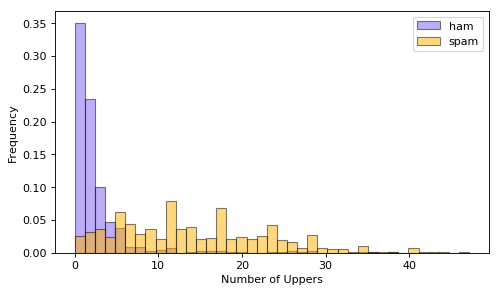

In [9]:
# function for generating a histogram! You don't need to know how it works, but feel free to see what each line does
def histogram_maker(dataset, separation_condition, plt, title, std=None, axis=False, show_hist=True):
    # gets ham texts from dataset
    hams = dataset.where("Class", are.equal_to("ham"))
    ham_texts = hams.column("Text")
    
    # gets spam texts from dataset
    spams = dataset.where("Class", are.equal_to("spam"))
    spam_texts = spams.column("Text")
    
    # calculate/collect values (from the seperation_condition) for each ham text
    ham_vals = []
    for count in range(len(ham_texts)):
        ham_vals += [separation_condition(ham_texts[count])]
        
    # calculate/collect values (from the seperation_condition) for each spam text
    spam_vals = []
    for count in range(len(spam_texts)):
        spam_vals += [separation_condition(spam_texts[count])]

    # calculate bin range for histogram
    all_vals_upper = ham_vals + spam_vals
    bins = np.linspace(min(all_vals_upper), np.percentile(all_vals_upper, 99), 40)
    
    # plot histogram
    if show_hist:
        if not axis:
            plt.figure(num=None, figsize=(7, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.hist(ham_vals, alpha=.5, bins=bins, color="#785EF0", label="ham", density=True)
        plt.hist(spam_vals, alpha=.5, bins=bins, color="#FFB000", label="spam", density=True)
        if not axis:
            plt.xlabel(title)
            plt.ylabel("Frequency")
        else:
            plt.set_xlabel(title)
            plt.set_ylabel("Frequency")
        plt.legend()
    
    # calculate and return the calculated values for ham and spam DIVIDED BY the standard deviation. This is to equally 
    # weigh each statistic when making the k-nearest neighbors plot 
    if std is None:
        stdev = np.std(all_vals_upper)
    else: 
        stdev = std
    ham_vals = [i/stdev for i in ham_vals]
    spam_vals = [i/stdev for i in spam_vals]

    return (ham_vals, spam_vals, stdev)

# define a function that returns the number of Upper case letters given a text
number_of_uppers_f = (lambda text : (len([i for i in text if i.isupper()])))
# generate histogram
ham_vals_number_uppers, spam_vals_number_uppers, std_number_uppers = histogram_maker(training, number_of_uppers_f, plt, "Number of Uppers")

From the histogram above, there is a statistical difference in the number of uppercase letters between spam and ham text messsages. However, this could be because perhaps spam messages are longer in general, and so have a higher number of upper case letters as a result. Next, lets try looking at the ratio of uppercase letters within a message (ie number of uppercase letters divided by the number of characters in a text):

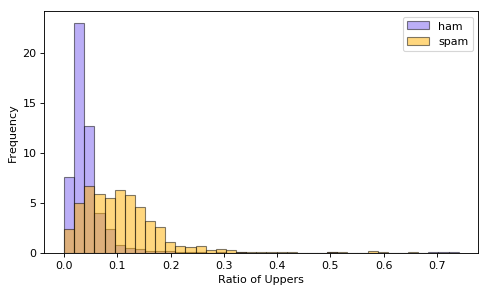

In [10]:
# define a function that returns the ratio of Upper case letters given a text
ratio_of_uppers_f = (lambda j : (len([i for i in j if i.isupper()])/len(j)))
# generate histogram
ham_vals_ratio_uppers, spam_vals_ratio_uppers, std_ratio_uppers = histogram_maker(training, ratio_of_uppers_f, plt, "Ratio of Uppers")

As you can see, it does indeed bring the spam distribution closer to the ham histogram. However, there still is a noticable shift in peaks between spam and ham messages.

This is one of many aspects that can differentiate spam vs ham messages. Discuss other features we can use to distinguish spam vs ham message in the box below.

(Double-click here)

How about we choose a specific group of characters to classify these messages; say we have certain "target characters," and we count the number of instances those characters are in the messages. We can expect a distinction between spam and ham messages, assuming we chose the right characters. We will be having you choosing some distinct characters to classify these messages. Here are some helpful guidelines in choosing these characters to make the best classifier:

* DO NOT chose half of the characters that are common among one group, then the other half among the other. Eg, do not choose 3 characters that are associated with ham messages, then 3 characters that are associated with spam messages. These characters are to be weighted EQUALY, and so getting a number like 3 could mean a message is either spam or ham. Try to find characters that are all associated with ham messages, or characters that are associated with spam messages.
    
* Try experiementing with the number of characters to choose, and which characters to choose!
    
* Consider maybe looking at punctuation, numbers, or even symbols.
    
* Need help thinking of words? Try going to the data folder and opening SMSSpamCollection.txt to read some spam/ham messages for inspiration!

In [11]:
# targets = []
# example targets list should look something like ["a", "B", "&", "7"]
targets = ["?", "!", "*"] + [i for i in string.ascii_uppercase] + [str(i) for i in range(0, 10)]
print(targets)

['?', '!', '*', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


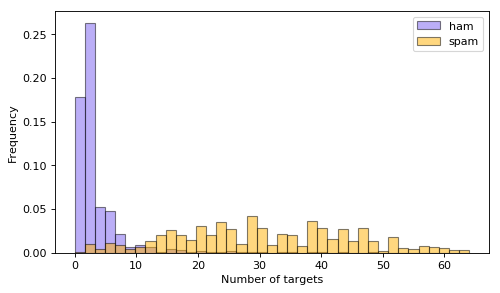

In [12]:
# define a function that returns the number of target characters given a text
num_of_targets_f = (lambda j : (len([i for i in j if i in targets])))
# generate histogram
ham_vals_num_targets, spam_vals_num_targets, std_num_targets = histogram_maker(training, num_of_targets_f, plt, "Number of targets")

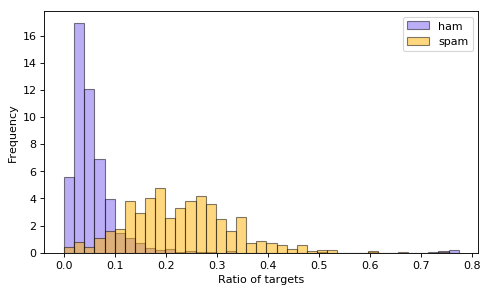

In [13]:
# define a function that returns the ratio of target characters given a text
ratio_of_targets_f = (lambda j : (len([i for i in j if i in targets])/len(j)))
# generate histogram
ham_vals_ratio_targets, spam_vals_ratio_targets, std_ratio_targets = histogram_maker(training, ratio_of_targets_f, plt, "Ratio of targets")

Now, let's look more general characteristics of the messages. For example, let's check out the distribution of the number of words and characters in a message:

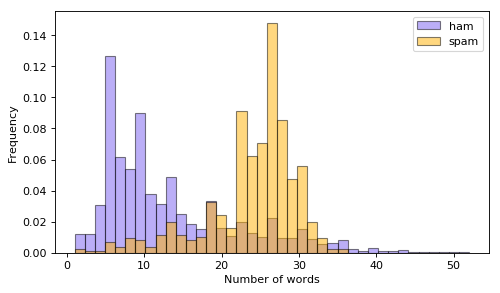

In [14]:
# define a function that returns the number of words given a text
num_words_f = (lambda j : (len([i for i in j.split(" ")])))
# generate histogram
ham_vals_num_words, spam_vals_num_words, std_num_words = histogram_maker(training, num_words_f, plt, "Number of words")

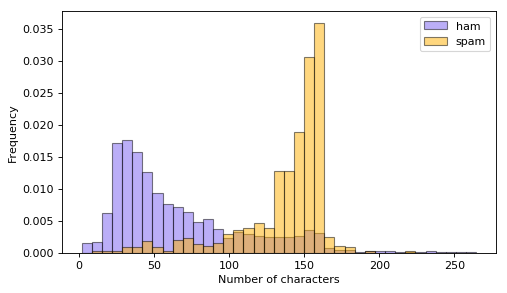

In [15]:
# define a function that returns the number of characters given a text
num_chara_f = (lambda j : (len(j)))
# generate histogram
ham_vals_num_chara, spam_vals_num_chara, std_num_chara = histogram_maker(training, num_chara_f, plt, "Number of characters")

If we combine both of these statistics, we can find the average characters per word attribute:

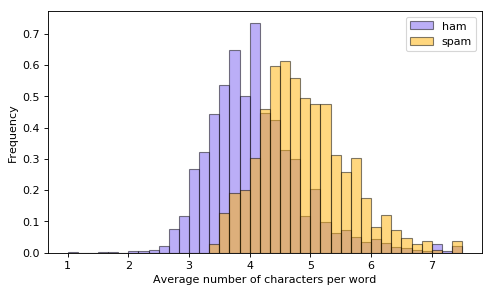

In [16]:
# define a function that returns the average number of characters per word given a text
avg_len_word_f = (lambda j : (len([i for i in j if i is not " "]))/(len([i for i in j.split(" ")])))
# generate histogram
ham_vals_avg_len_word, spam_vals_avg_len_word, std_avg_len_word = histogram_maker(training, avg_len_word_f, plt, "Average number of characters per word")

Now, if we plot one one attribute vs another, cluster the spam messages against the ham messages. Try plying around with the widget below to see which combination of attributes best differnetiate the spam messages vs the ham messages!

In [17]:
seps = [[('Number of Uppers', 0), ham_vals_number_uppers, spam_vals_number_uppers, std_number_uppers, number_of_uppers_f], 
        [('Ratio of Uppers', 1), ham_vals_ratio_uppers, spam_vals_ratio_uppers, std_ratio_uppers, ratio_of_uppers_f], 
        [('Number of Targets', 2), ham_vals_num_targets, spam_vals_num_targets, std_num_targets, num_of_targets_f],
        [('Ratio of Targets', 3), ham_vals_ratio_targets, spam_vals_ratio_targets, std_ratio_targets, ratio_of_targets_f], 
        [('Number of Words', 4), ham_vals_num_words, spam_vals_num_words, std_num_words, num_words_f], 
        [('Number of Characters', 5), ham_vals_num_chara, spam_vals_num_chara, std_num_chara, num_chara_f],
        [('Average len of words', 6), ham_vals_avg_len_word, spam_vals_avg_len_word, std_avg_len_word, avg_len_word_f],]

def plot_scatter(x, y):
    ham_x = seps[x][1]
    spam_x = seps[x][2]
    
    ham_y = seps[y][1]
    spam_y = seps[y][2]
    plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')
    
    ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 2), rowspan=1)
    ax1 = plt.subplot2grid((3, 3), (2, 2), rowspan=1)
    
    histogram_maker(training, seps[x][4], ax1, seps[x][0][0], axis=True)
    histogram_maker(training, seps[y][4], ax2, seps[y][0][0], axis=True)
    
    ax3.scatter(ham_x, ham_y, color="#785EF0", alpha=0.4, label="ham message")
    ax3.scatter(spam_x, spam_y, color="#FFB000", alpha=0.4, label="spam message")

    ax3.scatter([np.mean(ham_x)], [np.mean(ham_y)], marker="o", s=100, color="#785EF0", edgecolors="black", linewidths=2, label="centroid of ham")
    ax3.scatter([np.mean(spam_x)], [np.mean(spam_y)], marker="o", s=100, color="#FFB000", edgecolors="black", linewidths=2, label="centroid of spam")
    
    ax3.set_xlabel(seps[x][0][0] + " (Normalized)")
    ax3.set_ylabel(seps[y][0][0] + " (Normalized)")
    ax3.legend()
    
    ax3.axis([np.min(ham_x+spam_x), np.percentile(ham_x+spam_x, 99.9), np.min(ham_y+spam_y), np.percentile(ham_y+spam_y, 99.9)])
    plt.tight_layout()

interact(plot_scatter, x=[i[0] for i in seps], y=[i[0] for i in seps]);

interactive(children=(Dropdown(description='x', options=(('Number of Uppers', 0), ('Ratio of Uppers', 1), ('Nu…

K-Nearest Neighbors is an algorithm that makes predictions using previous examples. In our data, we find the SMS messages in the training set that are "nearest" to an SMS we want to filter as spam or ham. The SMS is then classified based on the how the majority of nearest messages are classified. 

Each message is plotted using a pair of attributes (called features) from a training dataset and identifies each attribute as one of two categories (called labels). In the spam dataset, the labels are "spam" and "ham." 

In [20]:
attributes = [3, 4]

In [21]:
def k_nearest_neighbors(testing, seps, attribute1, attribute2, k):
    attributes = [attribute1, attribute2]
    total_x = seps[attribute1][1]+seps[attribute1][2]
    total_y = seps[attribute2][1]+seps[attribute2][2]
    ham_length=len(seps[attributes[0]][1])

    all_points = []
    for i in range(len(total_x)):
        if i < ham_length:
            all_points += [[total_x[i], total_y[i], True]]
        else:
            all_points += [[total_x[i], total_y[i], False]]
            
    texts = testing.column("Text")
    ham_vals_x, spam_vals_x = histogram_maker(testing, seps[attribute1][4], plt, " ", 
                                              show_hist=False, std=seps[attribute1][3])[0:2]
    ham_vals_y, spam_vals_y = histogram_maker(testing, seps[attributes[1]][4], plt, " ", 
                                              show_hist=False, std=seps[attribute2][3])[0:2]
    
    test_points_ham = [[ham_vals_x[i], ham_vals_y[i], True] for i in range(0, len(ham_vals_x))]
    test_points_spam = [[spam_vals_x[i], spam_vals_y[i], False] for i in range(0, len(spam_vals_x))]
    test_points = test_points_ham + test_points_spam
    
    cor_ham = 0
    cor_spam = 0
    mislabel_as_ham = 0
    mislabel_as_spam = 0
    for point in test_points:
        def distance(x, y):
           return ((x-point[0])**2 + (y-point[1])**2)**0.5
        distance_distinction = [[distance(x, y), z] for x,y,z in all_points]
        distance_distinction.sort()
        top = distance_distinction[0:k]
        hams = np.sum([i[1] for i in top])
        if (hams >= k//2+1) and (point[2]):
            cor_ham+=1
        elif (hams >= k//2+1) and not (point[2]):
            mislabel_as_ham+=1
        elif (hams < k//2+1) and not (point[2]):
            cor_spam+=1
        elif (hams < k//2+1) and (point[2]):
            mislabel_as_spam+=1

    precision = (cor_ham)/(cor_ham+mislabel_as_ham)
    recall = (cor_ham)/(cor_ham+mislabel_as_spam)
    accuracy = (cor_ham+cor_spam)/(cor_ham+cor_spam+mislabel_as_ham+mislabel_as_spam)

    print("k: {}".format(k))
    print("1st attribute: {}".format(seps[attribute1][0][0]))
    print("2nd attribute: {}".format(seps[attribute2][0][0]))
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))
    print("accuracy: {}".format(accuracy))

    t = Table()
    return t.with_columns(" ", ["actual ham", "actual spam"], "predicted ham", [cor_ham, mislabel_as_ham], 
                          "predicted spam", [mislabel_as_spam, cor_spam])

k_nearest_neighbors(testing, seps, attributes[0], attributes[1], 3)

k: 3
1st attribute: Ratio of Targets
2nd attribute: Number of Words
precision: 0.9619450317124736
recall: 0.978494623655914
accuracy: 0.948339483394834


,predicted ham,predicted spam
actual ham,455,10
actual spam,18,59


### <font color = #2E5266>Feature Histograms</font>

<img style="display:inline;" src='data/img/numChar.png' width=45%>
<img style="display:inline;" src='data/img/numTargets.png' width=45%>
<img style="display:inline;" src='data/img/numUpprs.png' width=45%>
<img style="display:inline;" src='data/img/trgtRatio.png' width=45%>
<img style="display:inline;" src='data/img/upprRatio.png' width=45%>
<img style="display:inline;" src='data/img/avgChar.png' width=45%>

In [29]:
interact(k_nearest_neighbors, testing=fixed(testing), seps=fixed(seps), attribute1=[i[0] for i in seps], 
         attribute2=[i[0] for i in seps], k=widgets.IntSlider(min=1, max=1259, step=2, value=3, 
                                                              layout=Layout(width='80%')));

interactive(children=(Dropdown(description='attribute1', options=(('Number of Uppers', 0), ('Ratio of Uppers',…

The output above will show a confusion matrix for our selected features' predictions. 

* True positives - The top left cell counts messages that we predicted were ham, and actually are ham. 
* True negatives - The bottom right cell counts accurately predicted spam messages. 
* Type I Error - The top right counts messages classified as spam, but were actually ham, 
* Type II Error - The bottom left counts when we predicted ham, but it was actually spam. 

In [25]:
# Load post-op data.
raw_postop_data = Table.read_table("data/post-operative.csv")
# Show post-op data
raw_data.show(5)

L-CORE,L-SURF,L02,L-BP,SURF-STBL,CORE-STBL,BP-STBL,COMFORT,ADM-DECS
mid,low,excellent,mid,stable,stable,stable,15,A
mid,high,excellent,high,stable,stable,stable,10,S
high,low,excellent,high,stable,stable,mod-stable,10,A
mid,low,good,high,stable,unstable,mod-stable,15,A
mid,mid,excellent,high,stable,stable,stable,10,A
